# Networks Final Project: Initial Analysis

In [41]:
#imports
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

#constants
%matplotlib inline
sns.set_style("dark")
sigLev = 3
figWidth = figHeight = 8

In this notebook, I will initially begin to analyze the Offshore Leaks Database network.

In [32]:
#load in the dataset
fullNetwork = nx.read_gpickle("../data/processed/fullNetwork.pkl")

## Summary Statistics

We will begin by getting some general summary statistics on the network in terms of nodes, edges, and general network information.

### Node Information

In [33]:
numNodes = len(fullNetwork.nodes())

We see that there are {{numNodes}} nodes in this network.

In [36]:
#make function for getting information about particular nodes
def getNodeInfo(nodeVec,keyName):
    #helper for returning a list of node information over the whole list of
    #nodes
    nodeInfoDict = {"nodeID":[],keyName:[]}
    for nodeTup in nodeVec:
        #0th entry is ID
        nodeInfoDict["nodeID"].append(nodeTup[0])
        #then get key info
        givenNodeDict = nodeTup[1]
        nodeInfoDict[keyName].append(givenNodeDict[keyName])
    return nodeInfoDict
#then make data frame of information
nodeVec = fullNetwork.nodes(data = True)
nodeEntFrame = pd.DataFrame(getNodeInfo(nodeVec,"entType"))
nodeCountryFrame = pd.DataFrame(getNodeInfo(nodeVec,"countrycodes"))

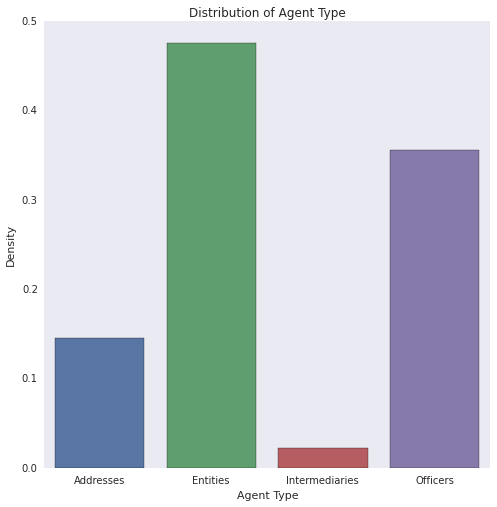

In [44]:
#then get entity distribution
entCountFrame = nodeEntFrame.groupby("entType",
                                     as_index = False)["nodeID"].count()
entCountFrame = entCountFrame.rename(columns = {"nodeID":"count"})
entCountFrame["density"] = entCountFrame["count"] / sum(entCountFrame["count"])
#then plot
givenFig = plt.figure(figsize = (figWidth,figHeight))
sns.barplot(x = "entType",y = "density",data = entCountFrame)
plt.xlabel("Agent Type")
plt.ylabel("Density")
plt.title("Distribution of Agent Type")

_Figure 1: Distribution of Agent Type._

We see that entities and officers make up a significant portion of the dataset. Interestingly, there are more entities than officers, which suggests that these dealings are very slim in terms of head count and tend to feature many different entities at once. Interestingly, Intermediaries take up a very small portion of the dataset. That being said, given my [original analysis for my proposal](../proposal/finalProjectProposal.pdf), it is likely that these intermediaries will play a very important part in the network.

In [49]:
countryCountFrame = nodeCountryFrame.groupby("countrycodes",
                                             as_index = False)["nodeID"].count()
countryCountFrame = countryCountFrame.rename(columns =
                                             {"countrycodes":"countryCode",
                                              "nodeID":"count"})
countryCountFrame = countryCountFrame.sort_values("count",ascending = False)
numCountryCodes = countryCountFrame.shape[0]

We see that there are {{numCountryCodes}} country codes represented in this dataset. Note that this is not necessarily

TODO:

* Fix link under Figure 1.
* Find out what "XXX" and ";" mean for a particular node's country code